In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import yaml
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

In [2]:
ids = [4, 5, 11, 12]
data = []
data_id = "all"

for the_id in ids:
    with open(f'/Users/bay1/merlin/merlin/examples/workflows/null_spec/scripts/my_data{the_id}.yaml') as f:
        data.append(yaml.safe_load(f))

ERROR
skipped concurrency 1
ERROR
skipped concurrency 2


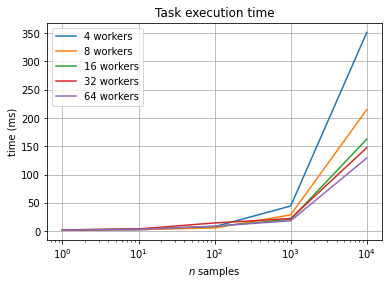

In [3]:
# TOTAL WF TIME
# OVERHEAD TYPE 2
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data[0].items():
        try:
            if f"c{con}_" in name and "start verify" in name:
                if "ERROR" in str(val):
                    print("ERROR")
                    break
                start_verify = (val + data[1][name] +  data[2][name] + data[3][name]) / 4
            if f"c{con}_" in name and "start run-workers" in name:
                start_run_workers = (val + data[1][name] +  data[2][name] + data[3][name]) / 4
                all_task_times.append((start_verify - start_run_workers))
        except:
            continue

    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
#plt.yscale("log")
ax.legend()

ax.set(xlabel='$n$ samples', ylabel='time (ms)',
               title='Task execution time')
ax.grid()

fig.savefig(f"figs/all_task_execution_time__{data_id}.png")
plt.show()

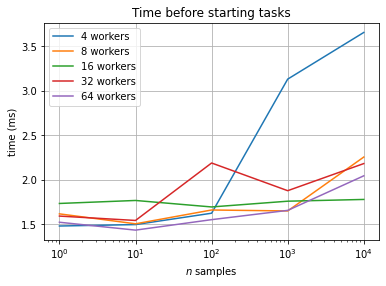

In [4]:
# TIME TO START WORKING ON TASKS
# OVERHEAD TYPE 4
    
concurrencies = [4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data[0].items():
        try:
            if f"c{con}_" in name and "start run-workers" in name:
                start_run_workers = (val + data[1][name] +  data[2][name] + data[3][name]) / 4
            if f"c{con}_" in name and "start samp1" in name:
                if "ERROR" in str(val):
                    print("ERROR")
                    break
                start_samp1 = (val + data[1][name] +  data[2][name] + data[3][name]) / 4
                all_task_times.append((start_samp1 - start_run_workers))
        except:
            continue
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
#plt.yscale("log")
ax.legend()

ax.set(xlabel='$n$ samples', ylabel='time (ms)',
               title='Time before starting tasks')
ax.grid()

fig.savefig(f"figs/task_start_time__{data_id}.png")
plt.show()

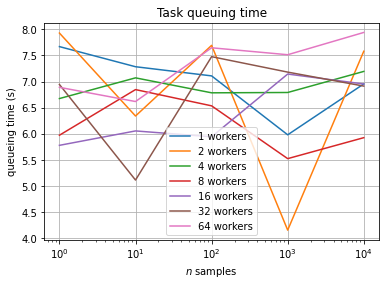

In [5]:
# TIME TO QUEUE ALL TASKS
# OVERHEAD TYPE 3
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data[0].items():
        try:
            #print(name)
            if f"c{con}_" in name and "merlin run" in name:
                queue_tasks = (val + data[1][name] +  data[2][name] + data[3][name]) / 4
                all_task_times.append(queue_tasks)
        except:
            continue
       
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue

    
plt.xscale("log")
ax.legend()

ax.set(xlabel='$n$ samples', ylabel='queueing time (s)',
               title='Task queuing time')
ax.grid()

fig.savefig(f"figs/task_queue_time__{data_id}.png")
plt.show()

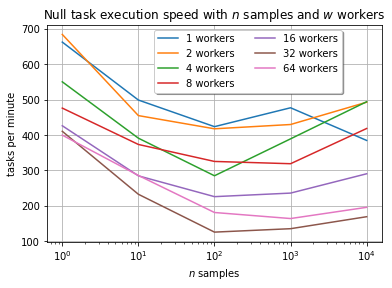

In [6]:
# TASK SPEED
# OVERHEAD TYPE 1
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    t_per_m = []
    for name, times in data[0].items():
        try:
            if f"c{con}_" in name and " " not in name:
                n_tasks = (len(times) + len(data[1][name]) + len(data[2][name]) + len(data[3][name])) / 4
                seconds = (sum(times) + sum(data[1][name]) + sum(data[2][name]) + sum(data[3][name])) / 4
                mins = seconds / 60.0
                tasks_per_min = n_tasks / mins
                t_per_m.append(tasks_per_min)
        except:
            continue
    try:
        ax.plot(samples, t_per_m, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue

plt.xscale("log")
ax.legend(loc='upper center', bbox_to_anchor=(0.6, 1.),
          ncol=2, fancybox=True, shadow=True)

ax.set(xlabel='$n$ samples', ylabel='tasks per minute',
               title='Null task execution speed')
ax.grid()

fig.savefig(f"figs/task_speed__{data_id}.png")
plt.show()

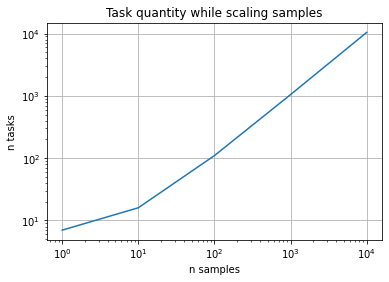

In [7]:
concurrency = 16

n_tasks = []
for sam in samples:
    for name, times in data[0].items():
        if name.endswith(f"_s{sam}") and name.startswith(f"c16_"):
            n_tasks.append(len(times))
            
fig, ax = plt.subplots()
ax.plot(samples, n_tasks)
plt.xscale("log")
plt.yscale("log")
ax.set(xlabel='n samples', ylabel='n tasks',
       title='Task quantity while scaling samples')
ax.grid()

#fig.savefig(f"figs/n_tasks3__{data_id}.png")
plt.show()

WITH OUTLIERS
292976 task times
17.961137083359063: max task time
0.21133474022709217: mean task time
0.05257832305505872: median task time
0.9504777567306553: standard deviation

WITHOUT OUTLIERS
265979 task times
142.05577783286572: max task time
55.03022041727314: mean task time
48.76078478991985: median task time
26.07438118382821: standard deviation


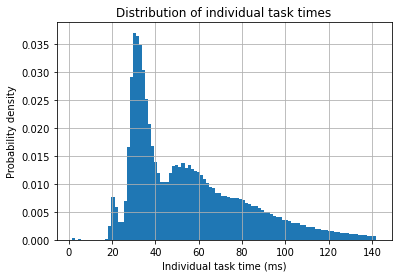

In [8]:
# OVERHEAD TYPE 1
# combining data from all concurrencies and sample quantities

def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

x = []
fig, ax = plt.subplots()

for the_data in data:
    for name, times in the_data.items():
        if " " not in name:
            x += times

x = np.array(x)
#mad = stats.median_absolute_deviation(x)
outlier_mask = is_outlier(x)

print("WITH OUTLIERS")
print(f"{len(x)} task times")
print(f"{max(x)}: max task time")
print(f"{np.mean(x)}: mean task time")
print(f"{np.median(x)}: median task time")
print(f"{np.std(x)}: standard deviation")
outliers = x[outlier_mask] * 1000
non_outliers = x[~outlier_mask] * 1000
print("\nWITHOUT OUTLIERS")
print(f"{len(non_outliers)} task times")
print(f"{max(non_outliers)}: max task time")
mu = np.mean(non_outliers)
print(f"{mu}: mean task time")
print(f"{np.median(non_outliers)}: median task time")
sigma = np.std(non_outliers)
print(f"{sigma}: standard deviation")

n_bins = 100

ax.grid()
n, bins, patches = plt.hist(non_outliers, bins=n_bins, histtype='bar', density=True, stacked=True)#, colors = ['red', 'tan', 'lime'])

# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#ax.plot(bins, y, '--')

plt.xlabel('Individual task time (ms)')
plt.ylabel('Probability density')
#ax.set(title=f'Individual task times: $\mu={round(np.mean(non_outliers),1)}$, $\sigma={round(np.std(non_outliers),1)}$')
ax.set(title=f'Distribution of individual task times')
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.savefig(f"figs/histogram__{data_id}.png")

plt.show()

###### 